In [1]:
# Created by Daria Savinkina
# CMC MSU, 2019
import os, sys

cycdir = '/home/sole/prj/GraduateWork/day2night/CycleGAN/'
inpath = '/mnt/w/prj/data/nexet/nexet_2017_1/testA'

sys.path.append(os.path.abspath(cycdir))

from options.test_options import TestOptions
from data import CreateDataLoader
from models import create_model
#from util.visualizer import save_images
#from util import html
import argparse
import torch
import torchvision.transforms as transforms
import pandas as pd
import glob
import cv2
from tqdm import tqdm_notebook as tqdm

import PIL
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from glob import glob
from IPython.display import display, Image
from io import BytesIO
from functools import partial

sys.path.append(os.path.abspath("/mnt/w/prj/GraduateWork/scripts/"))

from ImageDiff.compare import ImageDiff
from Any2Gif import any2gif

imd = ImageDiff(grayscale=False)
ssim = imd.ssim
mse = imd.mse
psnr = imd.psnr
load = imd.load_images
split = imd.get_splitted
to_image = imd.get_image
print_stats = imd.print_stats
save_stats = imd.save_stats

def concat_dir(image_dir_1, image_dir_2, concat_dir='img/concat', sort=True, resize=0):
    any2gif.img2img(iamge_dir_1, image_dir_2, concat_dir=concat_dir, sort=sort, resize=resize)

def concat(imageA, imageB, resize=0):
    if isinstance(imageA, str):
        imageA = imd.get_image(imageA, rgb=True)
    if isinstance(imageA, str):
        imageB = imd.get_image(imageB, rgb=True)
    c = imd.get_concated(imageA, imageB, to_rgb=False)
    if resize:
        c = img_resize(c, resize, opencv=True)
    return c
    
def display_img_array(ima):
    im = PIL.Image.fromarray(ima)
    bio = BytesIO()
    im.save(bio, format='png')
    display(Image(bio.getvalue(), format='png', retina=True))

def show(*images, plot=False, rgb=False):
    if plot:
        for im in images:
            if isinstance(im, str):
                im = to_image(im, rgb=rgb)
            plt.figure()
            plt.imshow(im, cmap="gray")
    else:
        for im in images:
            if isinstance(im, str):
                im = to_image(im, rgb=rgb)
            display_img_array(im)

In [2]:
def change_domain(model, opt, img, domain):
    
    osize = [int(round(opt.fineSize*opt.aspect_ratio)), opt.fineSize]
    tr =  transforms.Compose([transforms.Resize(osize, PIL.Image.BICUBIC), transforms.ToTensor()])

    img = tr(img).unsqueeze(0).to(model.device)
    
    if domain == 'A':
            img = model.netG_B(img)
    elif domain == 'B':
            img = model.netG_A(img)

    img = img.data[0].cpu().float().numpy()

    img = (np.transpose(img, (1, 2, 0)) + 1) / 2.0 * 255.0
    img = img.astype(np.uint8)

    return PIL.Image.fromarray(img)
        

In [3]:
!export CUDA_VISIBLE_DEVICES=0

In [6]:
288/512

0.5625

In [4]:
%cd $cycdir
opt = argparse.Namespace( aspect_ratio=0.5625, 
                   batch_size=1, 
                   checkpoints_dir='./checkpoints', 
                   dataroot=inpath, 
                   dataset_mode='single', 
                   direction='AtoB', 
                   display_winsize=256, 
                   display_id = -1,
                   which_epoch='latest', 
                   eval=False, 
                   fineSize=512,
                 #  fineSizey=512,
                   gpu_ids=[0], 
                   init_gain=0.02, 
                   init_type='normal', 
                   input_nc=3, 
                   isTrain=False, 
                   loadSize=256, 
                   max_dataset_size=float("inf"), 
                   model='cycle_gan', 
                   model_suffix='', 
                   n_layers_D=3, 
                   name='day2night', 
                   ndf=64, 
                   netD='basic', 
                   which_model_netG='resnet_9blocks', 
                  # which_model_netG='unet_256', 
                   ngf=64, no_dropout=True, 
                   no_flip=True, 
                   norm='instance', 
                   ntest=float("inf"), 
                   num_test=50, 
                   num_threads=1, 
                   output_nc=3, 
                   phase='test', 
                   resize_or_crop='resize_and_crop', 
                   results_dir='./results/', 
                   serial_batches=True, 
                   suffix='', 
                   verbose=False)

/mnt/w/prj/GraduateWork/day2night/CycleGAN


In [5]:
model = create_model(opt)
model.setup(opt)

initialize network with normal
initialize network with normal
model [CycleGANModel] was created
loading the model from ./checkpoints/day2night/latest_net_G_A.pth
loading the model from ./checkpoints/day2night/latest_net_G_B.pth
---------- Networks initialized -------------
[Network G_A] Total number of parameters : 11.378 M
[Network G_B] Total number of parameters : 11.378 M
-----------------------------------------------


In [1]:
def convert_dir(folder, set_name, prefix='_converted_cyclegan_test'):
    
    #folder = '/main/uni/diplom/pytorch-CycleGAN-and-pix2pix/datasets/day2night_clean/'
    #set_name = 'testB'
    
    if folder[-1] != '/':
        folder += '/'
    
    if not os.path.exists(folder + set_name + prefix):
        os.mkdir(folder + set_name + prefix)
    
    
    files = glob(folder + set_name + '/*')
    domain = set_name[-1]
    if domain == 'A':
        domain = 'B'
    else:
        domain = 'A'

    for file in tqdm(files):
        
        name = file[len(folder)+len(set_name)+1:]
        
        img_A = PIL.Image.open(file).convert('RGB')
        img_B = change_domain(model, opt, img_A, domain)
        img_B.save(folder + set_name + prefix +'/'+ name)

        
def get_image_from_nexet(name):
    if not name.endswith('.jpg'):
        name += '.jpg'
    if os.path.exists(os.path.join(data_dir, 'testA', name)):
        return os.path.join(data_dir, 'testA', name)
    if os.path.exists(os.path.join(data_dir, 'testB', name)):
        return os.path.join(data_dir, 'testB', name)
    if os.path.exists(os.path.join(data_dir, 'trainA', name)):
        return os.path.join(data_dir, 'trainA', name)
    if os.path.exists(os.path.join(data_dir, 'trainB', name)):
        return os.path.join(data_dir, 'trainB', name)
    print(f'No image {name} found')

In [7]:
#set_name = 'testB'

convert_dir(inpath, 'testA')
#convert_dir(folder, 'testB')
#convert_dir(folder, 'trainA')
#convert_dir(folder, 'trainB')

In [8]:
%cd /home/sole/prj/GraduateWork/notebooks/
img_As = [] #day
img_Bs = [] #night
# img_pathB= 'frame_0d08c1ee-8931-470c-b067-297b74fcb0ee_00000-1280_720.jpg'
img_pathA = 'frame_07dac603-778c-4b48-b596-2d84c36cdf13_00001-1280_720.jpg'
# img_pathB = frame_006854e4-7151-4eda-a0b1-d7d8187ee6ef_00000-1280_720.jpg
# img_pathB = 'frame_006854e4-7151-4eda-a0b1-d7d8187ee6ef_00000-1280_720.jpg'
img_pathB = 'frame_07d064ad-ebb4-4bf9-9dcc-1e138b35ae3d_00000-1280_720.jpg'
sides = ['B', 'A']
img_pathA = get_image_from_nexet(img_pathA)
img_pathB = get_image_from_nexet(img_pathB)


for img_path, side in zip([img_pathA, img_pathB],sides):

    img_A = PIL.Image.open(img_path).convert('RGB')

    img_As.append(img_A)

    img_B = change_domain(model, opt, img_A, side)
    img_A = img_A.resize(img_B.size)
    img_Bs.append(img_B)
 #   img_A

/mnt/w/prj/GraduateWork/notebooks


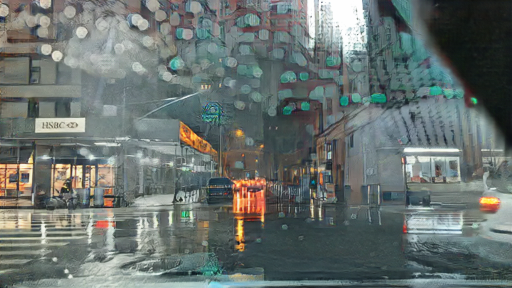

In [10]:
img_A
img_B

In [9]:
imgs = []
for img in img_As:
    img_A = img.resize(img_Bs[0].size)
    imgs.append(img_A)

In [10]:
x, y = img_Bs[0].size[0], img_Bs[0].size[1]

In [30]:
im = PIL.Image.new('RGB', (x*2, y*len(img_Bs)))

In [16]:
for i in range(len(imgs)):
    im.paste(imgs[i], (0, i*y))
for i in range(len(imgs)):
    im.paste(img_Bs[i], (x, i*y))

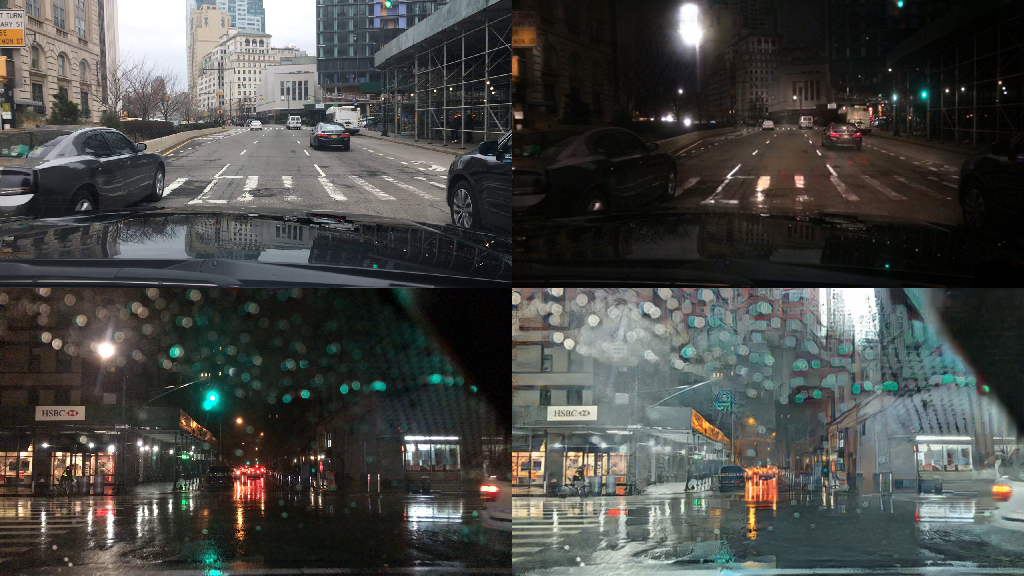

In [17]:
im

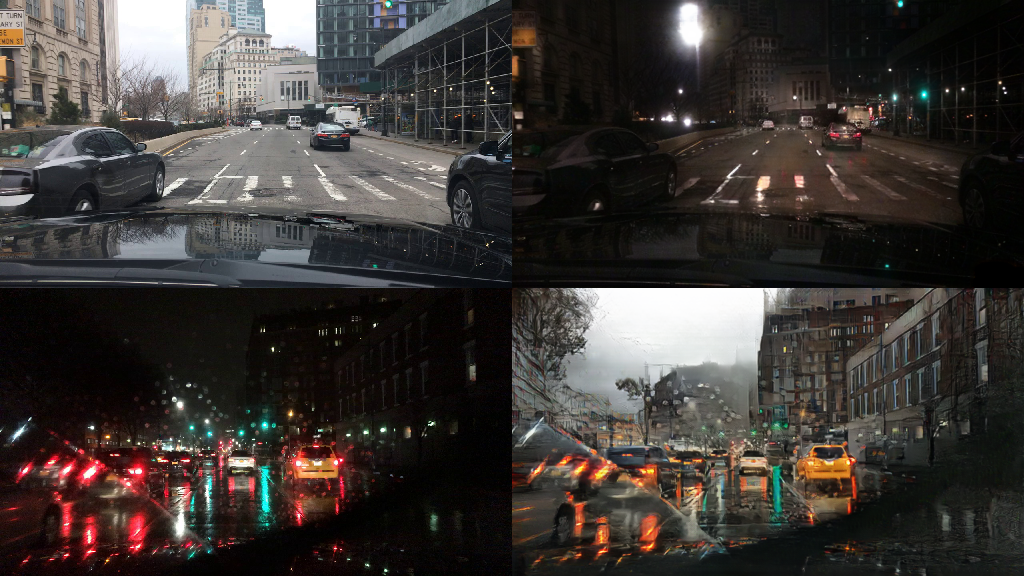

In [14]:
im

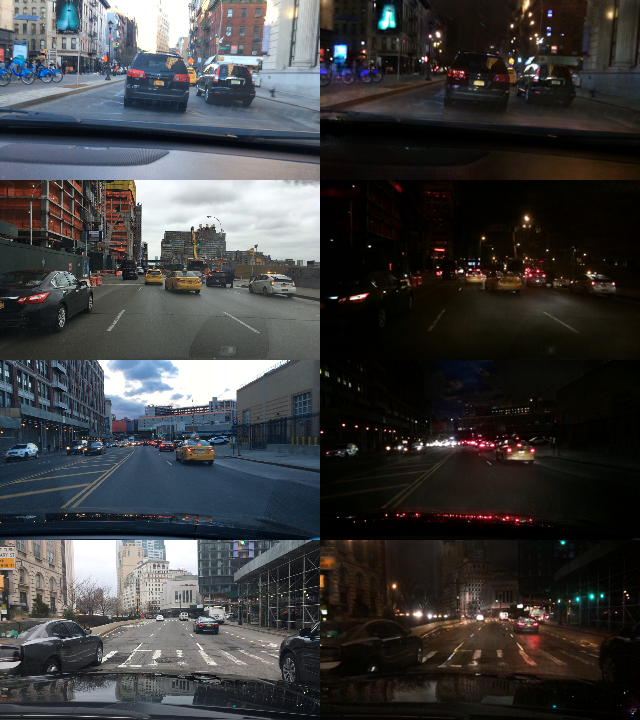

In [22]:
im

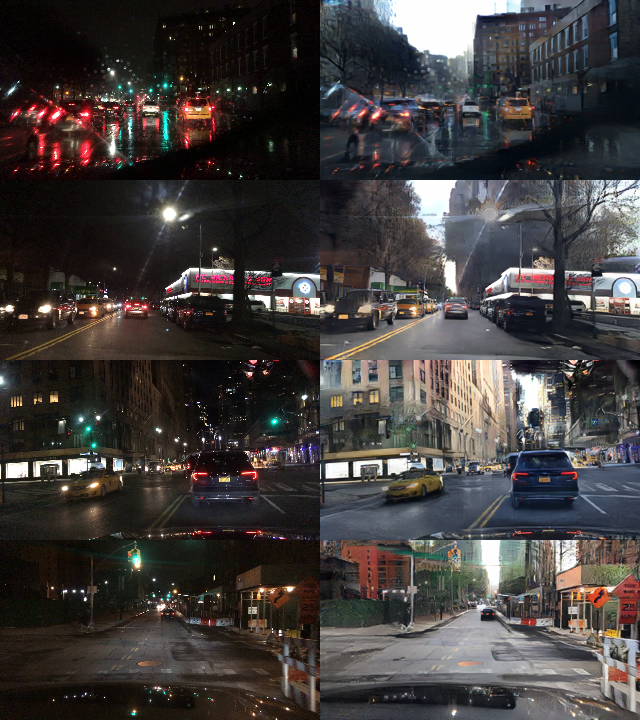

In [33]:
im

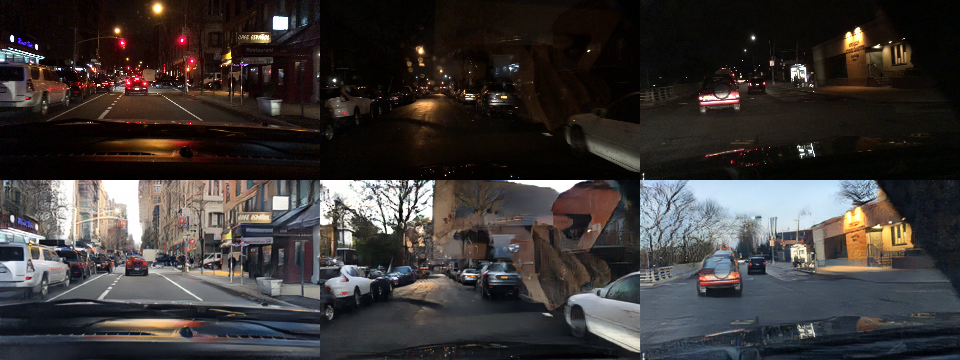

In [21]:
im